### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR

### define transformations 
- use them while downloading data

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize()
])



In [3]:
train = datasets.MNIST('./data',train=True, download=True, transform=train_transform)



#### Compute mean and std deviation for image normalization

In [4]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/home/anuda/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


#### Update transformation using mean and std from the training data

In [5]:
train_transforms = transforms.Compose([
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])


test_transforms = transforms.Compose([
        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])



### Apply transformation to both train and test dataset

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [7]:
type(train)

torchvision.datasets.mnist.MNIST

### Create Dataloader for batch generation

In [8]:
SEED = 1
cuda = torch.cuda.is_available()
print(cuda)

True


In [9]:
#for reproducibility
torch.cuda.manual_seed(SEED)


In [10]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

#### Show few images
- Create a data iter object
- fetch a batch of data using data loader

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

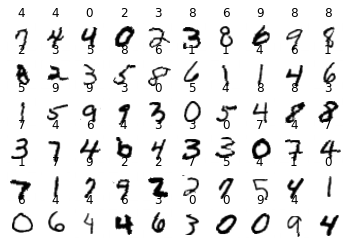

In [13]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.title(str(labels[index].item()))
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Create a Model
- will create like 5-7 layers of networks
- not use padding
- channels to be a minimal in number
- create multiple sequential blocks
- 28X28 > 26X26 > 24X24 > 22X22 > MP (11X11) > 9X9 > 7X7 > 1X1

In [14]:
from model import Net

### Visualize the model

In [15]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type='BN').to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           2,880
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12             [-1, 20, 9, 9]           3,600
      BatchNorm2d-13             [-1, 20, 9, 9]              40
             ReLU-14             [

### Training the Model

In [16]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = F.nll_loss(y_pred, target)
 
        train_losses.append(loss)
        
        loss.backward() #backward prop
        optimizer.step()
        
        pred = y_pred.argmax(dim=1, keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        pbar.set_description(desc=f'Loss = {loss.item()} Batch_id = {batch_idx}\
            Accuracy={100*correct/processed:0.2f}')
        
        
        train_acc.append(100*correct/processed)
        
        return(train_losses,test_losses,train_acc,test_acc)

        
def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    
    return(train_losses,test_losses,train_acc,test_acc)
            
        
        

In [17]:
model = Net(norm_type='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.9)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 0


Loss = 2.306048631668091 Batch_id = 0            Accuracy=10.16:   0%| | 0/469 [



Test set: Average loss: 2.3027, Accuracy: 607/10000 (6.07%)

EPOCH: 1


Loss = 2.2996420860290527 Batch_id = 0            Accuracy=10.16:   0%| | 0/469 



Test set: Average loss: 2.3025, Accuracy: 968/10000 (9.68%)

EPOCH: 2


Loss = 2.27020001411438 Batch_id = 0            Accuracy=17.19:   0%| | 0/469 [0



Test set: Average loss: 2.3025, Accuracy: 1009/10000 (10.09%)

EPOCH: 3


Loss = 2.2545557022094727 Batch_id = 0            Accuracy=24.22:   0%| | 0/469 



Test set: Average loss: 2.3025, Accuracy: 1007/10000 (10.07%)

EPOCH: 4


Loss = 2.221423387527466 Batch_id = 0            Accuracy=22.66:   0%| | 0/469 [



Test set: Average loss: 2.3024, Accuracy: 1008/10000 (10.08%)

EPOCH: 5


Loss = 2.2095489501953125 Batch_id = 0            Accuracy=25.78:   0%| | 0/469 



Test set: Average loss: 2.3024, Accuracy: 1008/10000 (10.08%)

EPOCH: 6


Loss = 2.2276253700256348 Batch_id = 0            Accuracy=22.66:   0%| | 0/469 



Test set: Average loss: 2.3022, Accuracy: 981/10000 (9.81%)

EPOCH: 7


Loss = 2.1497671604156494 Batch_id = 0            Accuracy=42.19:   0%| | 0/469 



Test set: Average loss: 2.3020, Accuracy: 788/10000 (7.88%)

EPOCH: 8


Loss = 2.161588668823242 Batch_id = 0            Accuracy=39.84:   0%| | 0/469 [



Test set: Average loss: 2.3017, Accuracy: 635/10000 (6.35%)

EPOCH: 9


Loss = 2.126275062561035 Batch_id = 0            Accuracy=35.94:   0%| | 0/469 [



Test set: Average loss: 2.3012, Accuracy: 627/10000 (6.27%)



2.306048631668091

In [32]:
# type(test_losses[0]),type(train_losses[0])
train_loss_cpu=[]
for i in range(0,len(train_losses)):
    train_loss_cpu.append(train_losses[i].cpu().item())
    

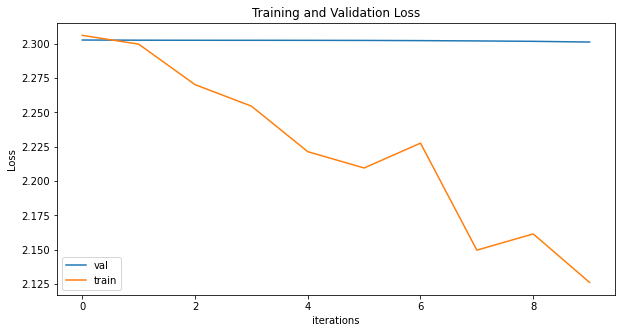

In [33]:
import matplotlib.pyplot as plt

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="val")
plt.plot(train_loss_cpu,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()